In [98]:
import sklearn

In [99]:
from sklearn.datasets import make_circles

In [100]:
n_sample = 1000

X, y = make_circles(n_sample,
                    noise=0.03,
                    random_state=42)

In [101]:
print(f"first 5 samples:, {X[:5]}")
print(f"first 5 labels: {y[:5]}")

first 5 samples:, [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 labels: [1 1 1 1 0]


In [102]:
import pandas as pd

In [103]:
circles = pd.DataFrame({
    "X1" : X[:, 0],
    "X2" : X[:, 1],
    "labels" : y

})

In [104]:
circles.head(10)


,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [105]:
import matplotlib.pyplot as plt

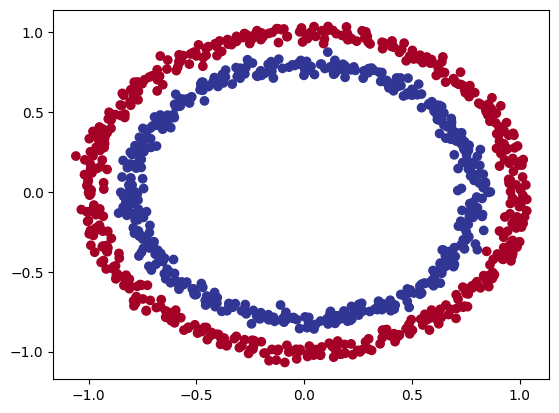

In [106]:
plt.scatter(
    x= X[:, 0],
    y = X[:, 1],
    c = y,
    cmap = plt.cm.RdYlBu
)

In [107]:
X.shape , y.shape

((1000, 2), (1000,))

In [108]:
import torch

In [109]:
X = torch.tensor(X , dtype = torch.float)
y = torch.tensor(y , dtype = torch.float)

In [110]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [111]:
from sklearn.model_selection import train_test_split

X_train , X_test, y_train , y_test = train_test_split(X ,y ,test_size = 0.2, random_state = 42 )

In [112]:
len(X_train) , len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [113]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "CPU"

In [114]:
device

'cuda'

In [115]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2 , out_features=5)
    self.layer_2 = nn.Linear(in_features = 5 , out_features=1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

model_0 = CircleModel().to(device)

In [116]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [117]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [118]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [119]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [120]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0', grad_fn=<SliceBackward0>)

In [121]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [122]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [123]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [124]:
epochs = 100

X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):

  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits , y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    if epochs % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796 | Acc: 51.88% | Test Loss: 0.69440 | Test Acc: 58.00%
Epoch: 1 | Loss: 0.69767 | Acc: 51.88% | Test Loss: 0.69420 | Test Acc: 57.50%
Epoch: 2 | Loss: 0.69741 | Acc: 52.00% | Test Loss: 0.69401 | Test Acc: 56.50%
Epoch: 3 | Loss: 0.69716 | Acc: 52.00% | Test Loss: 0.69385 | Test Acc: 56.50%
Epoch: 4 | Loss: 0.69694 | Acc: 51.50% | Test Loss: 0.69370 | Test Acc: 56.00%
Epoch: 5 | Loss: 0.69673 | Acc: 51.25% | Test Loss: 0.69356 | Test Acc: 56.00%
Epoch: 6 | Loss: 0.69654 | Acc: 51.38% | Test Loss: 0.69344 | Test Acc: 56.50%
Epoch: 7 | Loss: 0.69636 | Acc: 51.25% | Test Loss: 0.69333 | Test Acc: 56.50%
Epoch: 8 | Loss: 0.69619 | Acc: 51.38% | Test Loss: 0.69323 | Test Acc: 55.00%
Epoch: 9 | Loss: 0.69604 | Acc: 51.25% | Test Loss: 0.69314 | Test Acc: 54.00%
Epoch: 10 | Loss: 0.69590 | Acc: 51.25% | Test Loss: 0.69305 | Test Acc: 53.00%
Epoch: 11 | Loss: 0.69577 | Acc: 51.12% | Test Loss: 0.69298 | Test Acc: 52.00%
Epoch: 12 | Loss: 0.69564 | Acc: 51.12% | Test Los

In [125]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


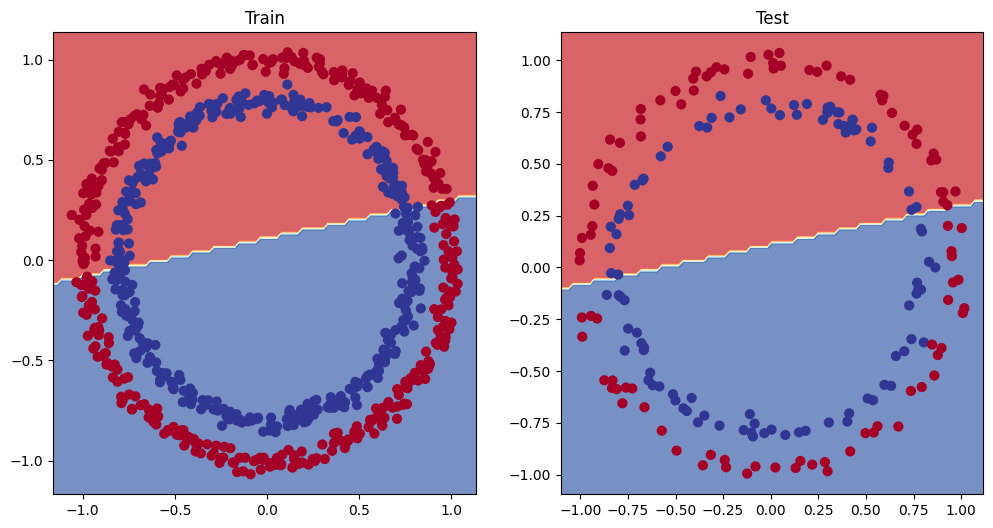

In [126]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Lets optimize the above model to imporve the accuracy and performance

In [135]:
class CircleModel2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features = 10 , out_features = 1)
    self.Relu = nn.ReLU()

  def forward(self , x):
    return self.layer_3(self.Relu(self.layer_2(self.Relu(self.layer_1(x)))))

model_1 = CircleModel2().to(device)
model_1

CircleModel2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (Relu): ReLU()
)

In [136]:
loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer_2 = torch.optim.SGD(params =model_1.parameters(), lr = 0.1)

In [137]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1500

X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)
for epochs in range(epochs):

  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn_2(y_logits,y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
  optimizer_2.zero_grad()
  loss.backward()
  optimizer_2.step()

  model_1.eval()

  with torch.inference_mode():

    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn_2(test_logits , y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    if epochs % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 99 | Loss: 0.69295 | Acc: 50.00% | Test Loss: 0.69319 | Test Acc: 50.00%
Epoch: 99 | Loss: 0.69115 | Acc: 52.88% | Test Loss: 0.69102 | Test Acc: 52.50%
Epoch: 99 | Loss: 0.68977 | Acc: 53.37% | Test Loss: 0.68940 | Test Acc: 55.00%
Epoch: 99 | Loss: 0.68795 | Acc: 53.00% | Test Loss: 0.68723 | Test Acc: 56.00%
Epoch: 99 | Loss: 0.68517 | Acc: 52.75% | Test Loss: 0.68411 | Test Acc: 56.50%
Epoch: 99 | Loss: 0.68102 | Acc: 52.75% | Test Loss: 0.67941 | Test Acc: 56.50%
Epoch: 99 | Loss: 0.67515 | Acc: 54.50% | Test Loss: 0.67285 | Test Acc: 56.00%
Epoch: 99 | Loss: 0.66659 | Acc: 58.38% | Test Loss: 0.66322 | Test Acc: 59.00%
Epoch: 99 | Loss: 0.65160 | Acc: 64.00% | Test Loss: 0.64757 | Test Acc: 67.50%
Epoch: 99 | Loss: 0.62362 | Acc: 74.00% | Test Loss: 0.62145 | Test Acc: 79.00%
Epoch: 99 | Loss: 0.56818 | Acc: 87.75% | Test Loss: 0.57378 | Test Acc: 86.50%
Epoch: 99 | Loss: 0.48153 | Acc: 93.50% | Test Loss: 0.49935 | Test Acc: 90.50%
Epoch: 99 | Loss: 0.37056 | Acc: 97.75% 

In [138]:
model_1.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()

y_preds[:10] , y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

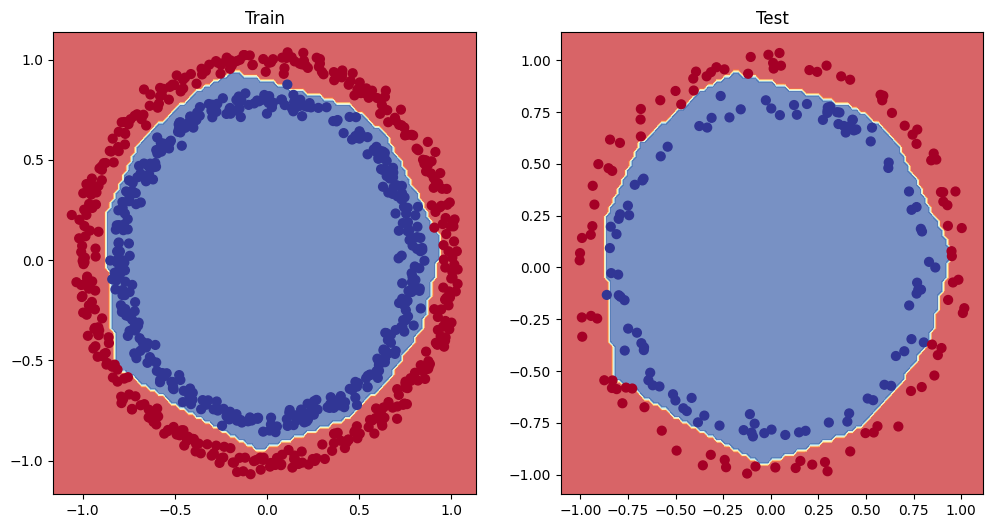

In [139]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)